<h1> Importing Drive Datasets </h1>

In [5]:
!git clone https://github.com/flori-margaritescu/human-judgements-honours.git

Cloning into 'human-judgements-honours'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 2), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), 4.34 KiB | 2.17 MiB/s, done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/distortion_triplets.zip" -d "/content/datasets/distortions"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/hsj_triplets.zip" -d "/content/datasets/hsj"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/birds_dataset_triplets.zip" -d "/content/datasets/birds-16"

### Imports

In [8]:
!pip install img2vec-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os

from img2vec_pytorch import Img2Vec

### Testing

Note: AlexNet and ResNet-18 take in completely different Tensor formats!

<h2> Note: the below package does the feature extraction for us aparently - careful with how you use it - better start from scratch for consistency of results!</h2>

In [12]:
# Initialize Img2Vec with GPU
img2vec_alexnet = Img2Vec(cuda=False, model="alexnet")  # default model resnet

# Read in an image (rgb format)
img = Image.open('test.png').convert('RGB')

# Get a vector from img2vec, returned as a torch FloatTensor
vec = img2vec_alexnet.get_vec(img, tensor=True)

print(vec.size())

# Initialize Img2Vec with GPU
img2vec_18 = Img2Vec(cuda=False, model="resnet-18")  # default model resnet

# Read in an image (rgb format)
img = Image.open('test.png').convert('RGB')
# Get a vector from img2vec, returned as a torch FloatTensor
vec = img2vec_18.get_vec(img, tensor=True)  

print(vec.size())

torch.Size([1, 4096])
torch.Size([1, 512, 1, 1])


In [13]:
ref = Image.open('ref.png').convert('RGB')
ref_vec = img2vec.get_vec(ref, tensor=True)

p0 = Image.open('p0.png').convert('RGB')
p0_vec = img2vec.get_vec(p0, tensor=True)

p1 = Image.open('p1.png').convert('RGB')
p1_vec = img2vec.get_vec(p1, tensor=True)

NameError: ignored

In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(ref_vec,
              p0_vec)
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.4113])



In [ ]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(ref_vec,
              p1_vec)
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.3291])



### Common functions for loading dataset

In [ ]:
def format_image_number(number):
    img_no_str = str(number)
    
    if len(img_no_str) == 1:
        im_no_name = "00000"
    elif len(img_no_str) == 2:
        im_no_name = "0000"
    elif len(img_no_str) == 3:
        im_no_name = "000"
    elif len(img_no_str) == 4:
        im_no_name = "00"
    elif len(img_no_str) == 5:
        im_no_name = "0"
    elif len(img_no_str) == 6:
        im_no_name = ""
        
    return im_no_name + img_no_str
    

def get_images_vector(path, number_of_images):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_list = []
    
    for image_no in range(number_of_images):
        image_no_str = str(image_no)
        
        im_no_name = format_image_number(image_no_str) + ".png"
        
        path_to_image = path + im_no_name

        feature_vector_image = Image.open(path_to_image).convert('RGB')
        feature_vec = img2vec.get_vec(feature_vector_image, tensor=True)
        feature_tensor_list.append(feature_vec)
        
    return feature_tensor_list

In [ ]:
def obtain_cosine_similarity_model_predictions(number_of_images, refs_vec_list, p0s_rec_list, p1s_rec_list):
    cosine_similarity_ref_and_p0 = []
    cosine_similarity_ref_and_p1 = []

    # list of predictions
    cosine_similarity_predictions = []
    
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

    for image_no in range(number_of_images): 
        reshaped_ref = torch.reshape(refs_vec_list[image_no], (1,512))
        reshaped_p0 = torch.reshape(p0s_rec_list[image_no], (1,512))
        reshaped_p1 = torch.reshape(p1s_rec_list[image_no], (1,512))
        
        cosine_similarity_ref_and_p0.append(cos(reshaped_ref, reshaped_p0))
        cosine_similarity_ref_and_p1.append(cos(reshaped_ref, reshaped_p1))

        if cosine_similarity_ref_and_p0[image_no] >= cosine_similarity_ref_and_p1[image_no]:
            cosine_similarity_predictions.append(0)
        else:
            cosine_similarity_predictions.append(1)   
            
    return cosine_similarity_predictions

In [ ]:
def obtain_prediction_accuracy(number_of_images, path_to_decision, actual_predictions):
    expected_decision_outputs = []

    for image_no in range(number_of_images):
            image_no_str = str(image_no)

            im_no_name = format_image_number(image_no_str) + ".npy"
            path_to_image = path_to_decision + im_no_name

            decision = np.load(path_to_image)

            if decision[0] <= 0.5: 
                expected_decision_outputs.append(0)
            else: 
                expected_decision_outputs.append(1)
                
    number_wrong_predictions = 0

    for image_no in range(number_of_images):
        if actual_predictions[image_no] != expected_decision_outputs[image_no]:
            number_wrong_predictions += 1

    accuracy = (number_of_images - number_wrong_predictions)/(number_of_images)
    
    return accuracy


In [ ]:
def reshape_tensor_list(dim, tensor_list):
    reshaped_list = []
    for t in tensor_list:
        reshaped_t = torch.reshape(t, (1,dim))
        reshaped_list.append(t)
    return reshaped_list

### 1. Resnet

In [ ]:
img2vec_res = Img2Vec(cuda=False, model="resnet-18")  # default model resnet

#### 1.1 Traditional

In [ ]:
traditional_refs = get_images_vector("val/traditional/ref/", 4720)
traditional_p0s = get_images_vector("val/traditional/p0/", 4720)
traditional_p1s = get_images_vector("val/traditional/p1/", 4720)

In [ ]:
print(len(traditional_refs))
print(len(traditional_p0s))
print(len(traditional_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions = obtain_cosine_similarity_model_predictions(4720, traditional_refs, traditional_p0s, traditional_p1s)

In [ ]:
prediction_accuracy = obtain_prediction_accuracy(4720, "val/traditional/judge/", actual_model_predictions)

In [ ]:
prediction_accuracy

0.8048728813559322

Prediction accuracy for Resnet-18 for traditional distortions: 0.8048728813559322

#### 1.2 CNN-based

In [ ]:
cnn_refs = get_images_vector("val/cnn/ref/", 4720)
cnn_p0s = get_images_vector("val/cnn/p0/", 4720)
cnn_p1s = get_images_vector("val/cnn/p1/", 4720)

In [ ]:
print(len(cnn_refs))
print(len(cnn_p0s))
print(len(cnn_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions_cnn_distortion = obtain_cosine_similarity_model_predictions(4720, cnn_refs, cnn_p0s, cnn_p1s)

In [ ]:
prediction_accuracy_cnn_distortion = obtain_prediction_accuracy(4720, "val/cnn/judge/", actual_model_predictions_cnn_distortion)

In [ ]:
prediction_accuracy_cnn_distortion

0.8442796610169492

Prediction accuracy for Resnet-18 for CNN-based distortions: 0.8442796610169492

#### 1.3 Colorization

In [ ]:
color_refs = get_images_vector("val/color/ref/", 4720)
color_p0s = get_images_vector("val/color/p0/", 4720)
color_p1s = get_images_vector("val/color/p1/", 4720)

In [ ]:
print(len(color_refs))
print(len(color_p0s))
print(len(color_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions_color_distortion = obtain_cosine_similarity_model_predictions(4720, color_refs, color_p0s, color_p1s)

In [ ]:
prediction_accuracy_color_distortion = obtain_prediction_accuracy(4720, "val/color/judge/", actual_model_predictions_color_distortion)

In [ ]:
prediction_accuracy_color_distortion

0.6533898305084745

Prediction accuracy for Resnet-18 for colorizaton distortions: 0.6533898305084745

#### 1.4 Deblurring --- IGNORE FOR NOW

In [ ]:
deb_refs = get_images_vector("val/deblur/ref/", 9440)
deb_p0s = get_images_vector("val/deblur/p0/", 9440)
deb_p1s = get_images_vector("val/deblur/p1/", 9440)

fi_refs = get_images_vector("val/frameinterp/ref/", 1888)
fi_p0s = get_images_vector("val/frameinterp/p0/", 1888)
fi_p1s = get_images_vector("val/frameinterp/p1/", 1888)

In [ ]:
print(len(deb_refs))
print(len(deb_p0s))
print(len(deb_p1s))

4720
4720
4720


In [ ]:
actual_model_predictions_deb_distortion = obtain_cosine_similarity_model_predictions(4720, deb_refs, deb_p0s, deb_p1s)

In [ ]:
prediction_accuracy_deb_distortion = obtain_prediction_accuracy(4720, "val/deblur/judge/", actual_model_predictions_deb_distortion)

In [ ]:
prediction_accuracy_deb_distortion

0.6016949152542372

Prediction accuracy for Resnet-18 for deblurring distortions: 0.6016949152542372

#### 1.4, 1.5 and 1.6 Deblurring, frame interpolation and super resolution

In [ ]:
deblur_refs = get_images_vector("val/deblur/ref/", 9440)
deblur_p0s = get_images_vector("val/deblur/p0/", 9440)
deblur_p1s = get_images_vector("val/deblur/p1/", 9440)
print("Deblurring is complete")

fi_refs = get_images_vector("val/frameinterp/ref/", 1888)
fi_p0s = get_images_vector("val/frameinterp/p0/", 1888)
fi_p1s = get_images_vector("val/frameinterp/p1/", 1888)
print("FI is complete")

spr_refs = get_images_vector("val/superres/ref/", 10856)
spr_p0s = get_images_vector("val/superres/p0/", 10856)
spr_p1s = get_images_vector("val/superres/p1/", 10856)
print("Spr is complete")

Deblurring is complete
FI is complete
Spr is complete


In [ ]:
actual_model_predictions_blur_distortion = obtain_cosine_similarity_model_predictions(9440, deblur_refs, deblur_p0s, deblur_p1s)
prediction_accuracy_blur_distortion = obtain_prediction_accuracy(9440, "val/deblur/judge/", actual_model_predictions_blur_distortion)
print("Deblur: ")
print(prediction_accuracy_blur_distortion)
print("----------------")
print("")
print("")

Deblur: 
0.6113347457627119
----------------




In [ ]:
actual_model_predictions_frame = obtain_cosine_similarity_model_predictions(1888, fi_refs, fi_p0s, fi_p1s)
prediction_accuracy_frame = obtain_prediction_accuracy(1888, "val/frameinterp/judge/", actual_model_predictions_frame)
print("Fi: ")
print(prediction_accuracy_frame)
print("----------------")
print("")
print("")

Fi: 
0.6604872881355932
----------------




In [ ]:
actual_model_predictions_cnn_distortion_super = obtain_cosine_similarity_model_predictions(10856, spr_refs, spr_p0s, spr_p1s)
prediction_accuracy_cnn_distortion_super = obtain_prediction_accuracy(10856, "val/superres/judge/", actual_model_predictions_cnn_distortion_super)
print("Spr: ")
print(prediction_accuracy_cnn_distortion_super)
print("----------------")
print("")
print("")

Spr: 
0.7198784082535004
----------------




Prediction accuracy for Resnet-18 for deblurring distortions: 0.6113347457627119

Prediction accuracy for Resnet-18 for frame interpolation distortions: 0.6604872881355932

Prediction accuracy for Resnet-18 for super resolution distortions: 0.7198784082535004

### 2. AlexNet

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os

from img2vec_pytorch import Img2Vec

def format_image_number(number):
    img_no_str = str(number)
    
    if len(img_no_str) == 1:
        im_no_name = "00000"
    elif len(img_no_str) == 2:
        im_no_name = "0000"
    elif len(img_no_str) == 3:
        im_no_name = "000"
    elif len(img_no_str) == 4:
        im_no_name = "00"
    elif len(img_no_str) == 5:
        im_no_name = "0"
    elif len(img_no_str) == 6:
        im_no_name = ""
        
    return im_no_name + img_no_str
    
img2vec = Img2Vec(cuda=False, model="alexnet")  # default model resnet

def get_images_vector(path, number_of_images):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_list = []
    
    for image_no in range(number_of_images):
        image_no_str = str(image_no)
        
        im_no_name = format_image_number(image_no_str) + ".png"
        
        path_to_image = path + im_no_name

        feature_vector_image = Image.open(path_to_image).convert('RGB')
        feature_vec = img2vec.get_vec(feature_vector_image, tensor=True)
        feature_tensor_list.append(feature_vec)
        
    return feature_tensor_list

def obtain_cosine_similarity_model_predictions(number_of_images, refs_vec_list, p0s_rec_list, p1s_rec_list):
    cosine_similarity_ref_and_p0 = []
    cosine_similarity_ref_and_p1 = []

    # list of predictions
    cosine_similarity_predictions = []
    
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

    for image_no in range(number_of_images): 
        reshaped_ref = refs_vec_list[image_no]
        reshaped_p0 = p0s_rec_list[image_no]
        reshaped_p1 = p1s_rec_list[image_no]
        
        cosine_similarity_ref_and_p0.append(cos(reshaped_ref, reshaped_p0))
        cosine_similarity_ref_and_p1.append(cos(reshaped_ref, reshaped_p1))

        if cosine_similarity_ref_and_p0[image_no] >= cosine_similarity_ref_and_p1[image_no]:
            cosine_similarity_predictions.append(0)
        else:
            cosine_similarity_predictions.append(1)   
            
    return cosine_similarity_predictions

def obtain_prediction_accuracy(number_of_images, path_to_decision, actual_predictions):
    expected_decision_outputs = []

    for image_no in range(number_of_images):
            image_no_str = str(image_no)

            im_no_name = format_image_number(image_no_str) + ".npy"
            path_to_image = path_to_decision + im_no_name

            decision = np.load(path_to_image)

            if decision[0] <= 0.5: 
                expected_decision_outputs.append(0)
            else: 
                expected_decision_outputs.append(1)
                
    number_wrong_predictions = 0

    for image_no in range(number_of_images):
        if actual_predictions[image_no] != expected_decision_outputs[image_no]:
            number_wrong_predictions += 1

    accuracy = (number_of_images - number_wrong_predictions)/(number_of_images)
    
    return accuracy


def reshape_tensor_list(dim, tensor_list):
    reshaped_list = []
    for t in tensor_list:
        reshaped_t = torch.reshape(t, (1,dim))
        reshaped_list.append(t)
    return reshaped_list



print("Alexnet results:")

img2vec_res = Img2Vec(cuda=False, model="alexnet")  # default model resnet

traditional_refs = get_images_vector("val/traditional/ref/", 4720)
traditional_p0s = get_images_vector("val/traditional/p0/", 4720)
traditional_p1s = get_images_vector("val/traditional/p1/", 4720)

cnn_refs = get_images_vector("val/cnn/ref/", 4720)
cnn_p0s = get_images_vector("val/cnn/p0/", 4720)
cnn_p1s = get_images_vector("val/cnn/p1/", 4720)

color_refs = get_images_vector("val/color/ref/", 4720)
color_p0s = get_images_vector("val/color/p0/", 4720)
color_p1s = get_images_vector("val/color/p1/", 4720)

deblur_refs = get_images_vector("val/deblur/ref/", 9440)
deblur_p0s = get_images_vector("val/deblur/p0/", 9440)
deblur_p1s = get_images_vector("val/deblur/p1/", 9440)
print("Deblurring is complete")

fi_refs = get_images_vector("val/frameinterp/ref/", 1888)
fi_p0s = get_images_vector("val/frameinterp/p0/", 1888)
fi_p1s = get_images_vector("val/frameinterp/p1/", 1888)
print("FI is complete")

spr_refs = get_images_vector("val/superres/ref/", 10856)
spr_p0s = get_images_vector("val/superres/p0/", 10856)
spr_p1s = get_images_vector("val/superres/p1/", 10856)
print("Spr is complete")


actual_model_predictions = obtain_cosine_similarity_model_predictions(4720, traditional_refs, traditional_p0s, traditional_p1s)
prediction_accuracy = obtain_prediction_accuracy(4720, "val/traditional/judge/", actual_model_predictions)
print("Traditional: ")
print(prediction_accuracy)
print("----------------")
print("")
print("")

actual_model_predictions_cnn_distortion = obtain_cosine_similarity_model_predictions(4720, cnn_refs, cnn_p0s, cnn_p1s)
prediction_accuracy_cnn_distortion = obtain_prediction_accuracy(4720, "val/cnn/judge/", actual_model_predictions_cnn_distortion)
print("CNN: ")
print(prediction_accuracy_cnn_distortion)
print("----------------")
print("")
print("")


actual_model_predictions_color_distortion = obtain_cosine_similarity_model_predictions(4720, color_refs, color_p0s, color_p1s)
prediction_accuracy_color_distortion = obtain_prediction_accuracy(4720, "val/color/judge/", actual_model_predictions_color_distortion)
print("Colorization: ")
print(prediction_accuracy_color_distortion)
print("----------------")
print("")
print("")

actual_model_predictions_blur_distortion = obtain_cosine_similarity_model_predictions(9440, deblur_refs, deblur_p0s, deblur_p1s)
prediction_accuracy_blur_distortion = obtain_prediction_accuracy(9440, "val/deblur/judge/", actual_model_predictions_blur_distortion)
print("Deblur: ")
print(prediction_accuracy_blur_distortion)
print("----------------")
print("")
print("")


actual_model_predictions_frame = obtain_cosine_similarity_model_predictions(1888, fi_refs, fi_p0s, fi_p1s)
prediction_accuracy_frame = obtain_prediction_accuracy(1888, "val/frameinterp/judge/", actual_model_predictions_frame)
print("Fi: ")
print(prediction_accuracy_frame)
print("----------------")
print("")
print("")

actual_model_predictions_cnn_distortion_super = obtain_cosine_similarity_model_predictions(10856, spr_refs, spr_p0s, spr_p1s)
prediction_accuracy_cnn_distortion_super = obtain_prediction_accuracy(10856, "val/superres/judge/", actual_model_predictions_cnn_distortion_super)
print("Spr: ")
print(prediction_accuracy_cnn_distortion_super)
print("----------------")
print("")
print("")

Alexnet results:
Deblurring is complete
FI is complete
Spr is complete
Traditional: 
0.8108050847457627
----------------


CNN: 
0.8544491525423729
----------------


Colorization: 
0.6720338983050848
----------------


Deblur: 
0.639406779661017
----------------


Fi: 
0.666843220338983
----------------


Spr: 
0.7424465733235077
----------------




AlexNet: 
    
Traditional: 
0.8108050847457627


CNN: 
0.8544491525423729



Colorization: 
0.6720338983050848



Deblur: 
0.639406779661017



Fi: 
0.666843220338983



Spr: 
0.7424465733235077

<h1> NEW START HERE </h1>

Link: https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
 + modify to adhere to current PyTorch updates

*What we have done here is created a reference to the layer we want to extract from. Deciding on which layer to extract from is a bit of a science, but something to keep in mind is that early layers in the network are usually learning high-level features such as ‘image contains fur’ or ‘image contains round object’, while lower-level features are more specific to the training data. The ‘avgpool’ layer selected here is at the end of ResNet-18, but if you plan to use images that are very different from ImageNet, you may benefit in using an ealier layer or fine-tuning the model.*

Conclusion for me: because later layers are more specific to training data THEN I am expecting all models to perform much better on HSJ and the worst on Distortions.


**But if you plan to use images that are very different from ImageNet, you may benefit in using an ealier layer or fine-tuning the model.**

In [53]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image

In [54]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
model.cuda()
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')
# Set model to evaluation mode
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Set model to evaluation mode
model.eval()

In [56]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)

In [59]:
def get_vector(image_name):
    
#     # Load the pretrained model
#     model = models.resnet18(pretrained=True)
#     # Use the model object to select the desired layer
#     layer = model._modules.get('avgpool')
    
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    
    # M1: my_embedding = torch.zeros(1, 512, 1, 1) and later my_embedding.copy_(o.data)
    # M2: my_embedding = torch.zeros(512) and later my_embedding.copy_(o.data.reshape(o.data.size(1)))
    my_embedding = torch.zeros(512).cuda()
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [60]:
query_vector = get_vector("ref.png")
ref1_vector = get_vector("p0.png")
ref2_vector = get_vector("p1.png")

In [61]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(query_vector.unsqueeze(0),
              ref1_vector.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.8143], device='cuda:0')



In [62]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(query_vector.unsqueeze(0),
              ref2_vector.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.5251], device='cuda:0')



In [75]:
def get_image_embeddings(path, image_type):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name))

        # now load decision
        decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
        decision = np.load(path+"/judge/"+decision_no_name)
        if decision[0] <= 0.5: 
              feature_tensor_dict["decision"].append(0)
        else: 
              feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict

In [76]:
%cd /content

/content


In [77]:
resnet_18_embedddings = get_image_embeddings("datasets/distortions/distortion_triplets/traditional_triplets", "png")

In [ ]:
resnet_18_embedddings["decision"]

In [87]:
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy

In [88]:
predictions = get_predictions(resnet_18_embedddings)
accuracy = get_accuracy(predictions, resnet_18_embedddings)

In [89]:
accuracy

0.809

<h1> Working framework start </h1>

In [92]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image

############################ REQUIRES MODIFICATION FOR EACH MODEL 

# scaler = transforms.Resize((224, 224))
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()   # used to convert the PIL image to a PyTorch tensor (multidimensional array)
############################


############################## HOW TO GET MODEL:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)
# model.cuda()
# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')
# # Set model to evaluation mode
# model.eval()

##################################

def get_vector(image_name, model, layer, scaler, normalize):
    
#     # Load the pretrained model
#     model = models.resnet18(pretrained=True)
#     # Use the model object to select the desired layer
#     layer = model._modules.get('avgpool')
    
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).cuda()
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    
    # M1: my_embedding = torch.zeros(1, 512, 1, 1) and later my_embedding.copy_(o.data)
    # M2: my_embedding = torch.zeros(512) and later my_embedding.copy_(o.data.reshape(o.data.size(1)))
    my_embedding = torch.zeros(512).cuda()
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding
    

############################ COSINE SIMILARITY
cos = nn.CosineSimilarity(dim=1, eps=1e-6)


########################### GET FEATURE VECTORS
def get_image_embeddings(path, image_type, model, layer, scaler, normalize):  # returns a list of tensors
    # path of form: traditional/ref/
    feature_tensor_dict = dict()
    feature_tensor_dict["ref"] = []
    feature_tensor_dict["p0"] = []
    feature_tensor_dict["p1"] = []
    feature_tensor_dict["decision"] = []
    
    for image_no in range(1000):
        im_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + "." + image_type
        
        feature_tensor_dict["ref"].append(get_vector(path+"/ref/" + im_no_name, model, layer, scaler, normalize))
        feature_tensor_dict["p0"].append(get_vector(path+"/p0/" + im_no_name, model, layer, scaler, normalize))
        feature_tensor_dict["p1"].append(get_vector(path+"/p1/" + im_no_name, model, layer, scaler, normalize))

        # now load decision
        decision_no_name =  (6-len(str(image_no)))*"0" + str(image_no) + ".npy"
        decision = np.load(path+"/judge/"+decision_no_name)
        if decision[0] <= 0.5: 
              feature_tensor_dict["decision"].append(0)
        else: 
              feature_tensor_dict["decision"].append(1)
        
    return feature_tensor_dict


########################## GET MODEL PREDICTIONS
def get_predictions(embeddings):
  cosine_similarity_dict = dict()
  cosine_similarity_dict["ref_and_p0"] = []
  cosine_similarity_dict["ref_and_p1"] = []
  cosine_similarity_predictions = []

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # cos_sim = cos(query_vector.unsqueeze(0), ref2_vector.unsqueeze(0))

  for image_no in range(1000):
      cosine_similarity_dict["ref_and_p0"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p0"][image_no].unsqueeze(0)))
      cosine_similarity_dict["ref_and_p1"].append(cos(embeddings["ref"][image_no].unsqueeze(0), embeddings["p1"][image_no].unsqueeze(0)))
      
      if cosine_similarity_dict["ref_and_p0"][image_no] >= cosine_similarity_dict["ref_and_p1"][image_no]:
          cosine_similarity_predictions.append(0)
      else:
          cosine_similarity_predictions.append(1)   
  return cosine_similarity_predictions

########################## GET MODEL ACCURACY
def get_accuracy(predictions,embeddings):
  decisions = embeddings["decision"]

  number_wrong_predictions = 0

  for image_no in range(1000):
      if predictions[image_no] != decisions[image_no]:
          number_wrong_predictions += 1
      
  accuracy = (1000 - number_wrong_predictions)/(1000)
  return accuracy


def apply_framework(path, image_type, model, layer, scaler, normalize):
  embeddings = get_image_embeddings(path, 
                                    image_type,
                                    model, layer, scaler, normalize)
  predictions= get_predictions(embeddings)
  accuracy = get_accuracy(predictions, embeddings)
  print(path + ": " + str(accuracy))
  return accuracy

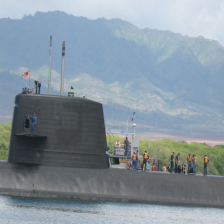

In [97]:
    # 1. Load the image with Pillow library
img = Image.open("datasets/hsj/hsj_triplets/hsj_query_rank0_dissimilar/p0/000000.jpg").convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
t_img = scaler(img)
t_img

1. Resnet-18 + cosine similarity

In [95]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
model.cuda()
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')
# Set model to evaluation mode
model.eval()
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

print("# ----------------------------------------BAPPS 2AFC DIST RESNET-18------------------------#")
print("")
################### TRADITIONAL 
apply_framework("datasets/distortions/distortion_triplets/traditional_triplets",
                "png",
                model, layer, scaler, normalize)

################ CNN
apply_framework("datasets/distortions/distortion_triplets/cnn_triplets",
                "png",
                model, layer, scaler, normalize)

############### COLOR
apply_framework("datasets/distortions/distortion_triplets/color_triplets",
                "png",
                model, layer, scaler, normalize)

################ DEBLUR
apply_framework("datasets/distortions/distortion_triplets/deblur_triplets",
                "png",
                model, layer, scaler, normalize)

############### FRAME INTERP
apply_framework("datasets/distortions/distortion_triplets/frameinterp_triplets",
                "png",
                model, layer, scaler, normalize)

################ SUPER RES
apply_framework("datasets/distortions/distortion_triplets/superres_triplets",
                "png",
                model, layer, scaler, normalize)

# datasets/distortions/distortion_triplets/traditional_triplets: 0.809
# datasets/distortions/distortion_triplets/cnn_triplets: 0.848
# datasets/distortions/distortion_triplets/color_triplets: 0.623
# datasets/distortions/distortion_triplets/deblur_triplets: 0.603
# datasets/distortions/distortion_triplets/frameinterp_triplets: 0.663
# datasets/distortions/distortion_triplets/superres_triplets: 0.723

# ----------------------------------------BAPPS 2AFC DIST RESNET-18------------------------#

datasets/distortions/distortion_triplets/traditional_triplets: 0.809
datasets/distortions/distortion_triplets/cnn_triplets: 0.848
datasets/distortions/distortion_triplets/color_triplets: 0.623
datasets/distortions/distortion_triplets/deblur_triplets: 0.603
datasets/distortions/distortion_triplets/frameinterp_triplets: 0.663
datasets/distortions/distortion_triplets/superres_triplets: 0.723


0.723

In [ ]:
print("# ----------------------------------------HSJ------------------------#")
